In [2]:
# imports
from astropy.table import QTable
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline

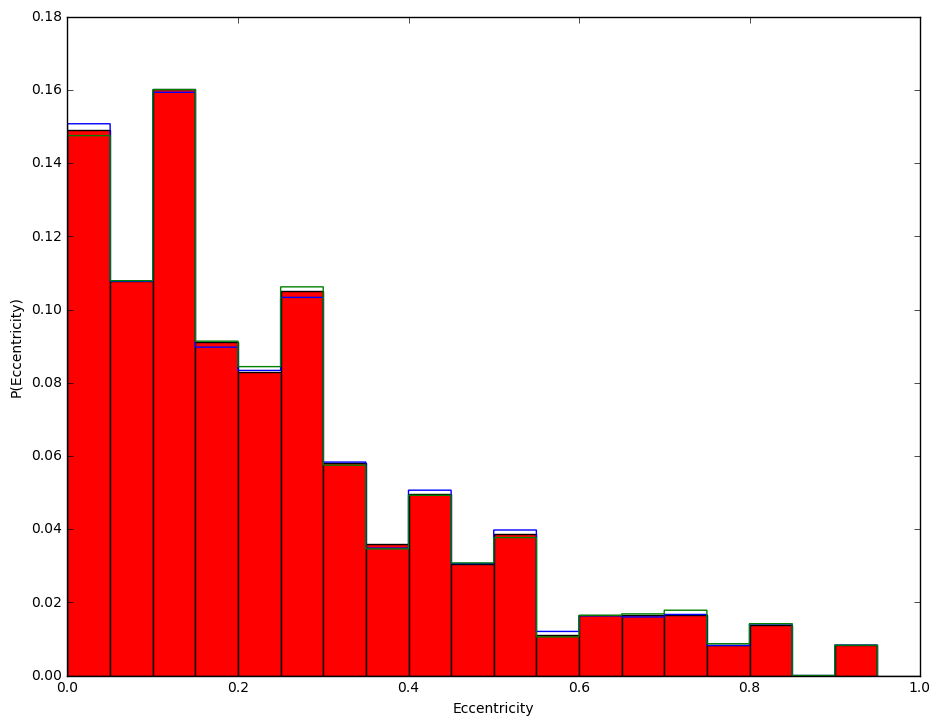

In [3]:
# now able to run entire notebook and produce the relevant parameters and figures.  

data = QTable.read('probecc_comma.dat',format='ascii.no_header')


data.rename_column('col1','ecc')
data.rename_column('col2','% in bin')
data.rename_column('col3','cum %')
x = np.arange(0,1,0.05)
y = data['cum %']
ecc_inbin = data['% in bin']
cum=data['cum %']
binwidth = 0.05
fig,ax=plt.subplots(1,1)
fig.set_size_inches(11,8.5)                  

bar = ax.bar(data['ecc'],ecc_inbin,width=0.05,color='r')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('P(Eccentricity)')

t = 25000 # number of sims to run

# generates list of ecc for b.in
n = 0
ecc_list_b = np.array([])
while n <= t-1:
    r = (np.random.sample(1)) #some y value (percentage)
    if r <= 0.149171270718232:
        bin_lower=0.0
        bin_upper=0.05
    else:
        r_mask = np.where(y<=r)
        x_below = x[r_mask]
        x_below = np.append(x_below,x_below[-1]+0.05)
        bin_upper = x_below[-1]+0.05
        bin_lower = x_below[-2]+0.05
    rand = np.random.uniform(0,0.05,1)
    ecc = bin_lower + rand 
    ecc_list_b=np.append(ecc_list_b,ecc)
    n += 1
    continue
ecc_hist_b = ax.hist(ecc_list_b,bins=x,weights=np.zeros_like(ecc_list_b)+1./ecc_list_b.size,histtype='step',color='blue')

# generates list of ecc for c.in
n = 0
ecc_list_c = np.array([])
while n <= t-1:
    r = (np.random.sample(1)) #some y value (percentage)
    if r <= 0.149171270718232:
        bin_lower=0.0
        bin_upper=0.05
    else:
        r_mask = np.where(y<=r)
        x_below = x[r_mask]
        x_below = np.append(x_below,x_below[-1]+0.05)
        bin_upper = x_below[-1]+0.05
        bin_lower = x_below[-2]+0.05
    rand = np.random.uniform(0,0.05,1)
    ecc = bin_lower + rand 
    ecc_list_c=np.append(ecc_list_c,ecc)
    n += 1
    continue
ecc_hist_c = ax.hist(ecc_list_c,bins=x,weights=np.zeros_like(ecc_list_c)+1./ecc_list_c.size,histtype='step',color='green')




R_crit = 2 * u.earthRad

# now to generate ICs and their files. 
# clears vars and generates new randoms
# b.in
mass_list_b = np.array([]) #if radius < 2 R_earth, then mass = ((R/R_earth)**(3.68))*M_earth; if larger, density = 1g/cm**3
ecc_b = ecc_list_b
rad_list_b = np.random.uniform(0.5,10,25000) * u.earthRad # [0.5,10] R_earth;  
Qp_b = np.array([]) # [30,300] # [10**6,10**7]
semi_b = np.random.uniform(0.01,0.15,25000) # [0.01,0.15] AU

# c.in
mass_list_c = np.array([])
ecc_c = ecc_list_c
rad_list_c = np.random.uniform(0.5,10,25000) * u.earthRad
Qp_c = np.array([])
semi_c = np.array([])

for a_b in semi_b: # makes sure semi_c is always > semi_b
    a_c = np.random.uniform(a_b,0.5,1)
    semi_c = np.append(semi_c,a_c)


# star.in
stellar_mass = np.random.uniform(0.7,1.4,25000) # [0.7,1.4] M_sun
stellar_radius = np.random.uniform(0.7,1.4,25000) #[0.7,1.4] R_sun
Qstar = np.random.uniform(10**6,10**7,25000) # [10**6,10**7]

# vpl.in
Ages = np.random.uniform(2*10**9,8*10**9,25000) # [2,8] Gyrs

# mass calculations
def calc_mass_l2(radius):
    r = radius
    mass = ((r/const.R_earth)**(3.68))*const.M_earth
    return mass

def calc_mass_g2(radius):
    r = radius
    r = r.to(u.cm)
    volume = (4*np.pi*r**3)/3
    density = (1*u.g)/(1*u.cm)**3
    mass = volume * density
    return mass

# determining mass and Qp based on radius; b.in
for r in rad_list_b:
    if r < 2*u.earthRad:
        mass = calc_mass_l2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(30,301)
    else:
        mass = calc_mass_g2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(10**6,(10**7)+1)
    mass_list_b = np.append(mass_list_b,mass.value)
    Qp_b = np.append(Qp_b,Qplanet)


# determining mass and Qp based on radius; c.in    
for r in rad_list_c:
    if r < 2*u.earthRad:
        mass = calc_mass_l2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(30,301)
    else:
        mass = calc_mass_g2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(10**6,(10**7)+1)
    mass_list_c = np.append(mass_list_c,mass.value)
    Qp_c = np.append(Qp_c,Qplanet)

        

rad_list_b = rad_list_b.value
rad_list_c = rad_list_c.value



3932 21068 25000


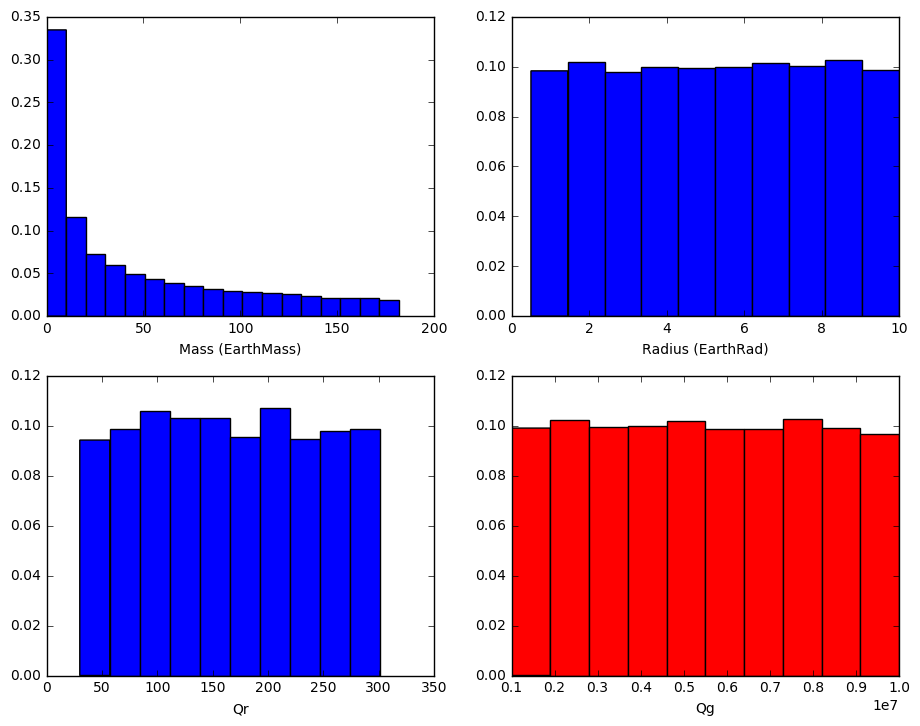

In [7]:
#distributions for b.in of mass,Qp, Radius
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_list_b)-min(mass_list_b)
ax[0,0].hist(mass_list_b,bins=18,weights=np.zeros_like(mass_list_b)+1./mass_list_b.size) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(rad_list_b,weights=np.zeros_like(rad_list_b)+1./rad_list_b.size) # Uniform
q_lower = np.where(Qp_b<=301)
q_upper = np.where(Qp_b>301) 
ax[1,0].hist(Qp_b[q_lower],weights=np.zeros_like(Qp_b[q_lower])+1./Qp_b[q_lower].size) 
ax[1,1].hist(Qp_b[q_upper],weights=np.zeros_like(Qp_b[q_upper])+1./Qp_b[q_upper].size,color='r')

ax[0,0].set_xlabel('Mass (EarthMass)')
ax[0,1].set_xlabel('Radius (EarthRad)')
ax[1,0].set_xlabel('Qr')
ax[1,1].set_xlabel('Qg')

print(Qp_b[q_lower].size,Qp_b[q_upper].size,Qp_b[q_lower].size + Qp_b[q_upper].size)

3941 21059 25000


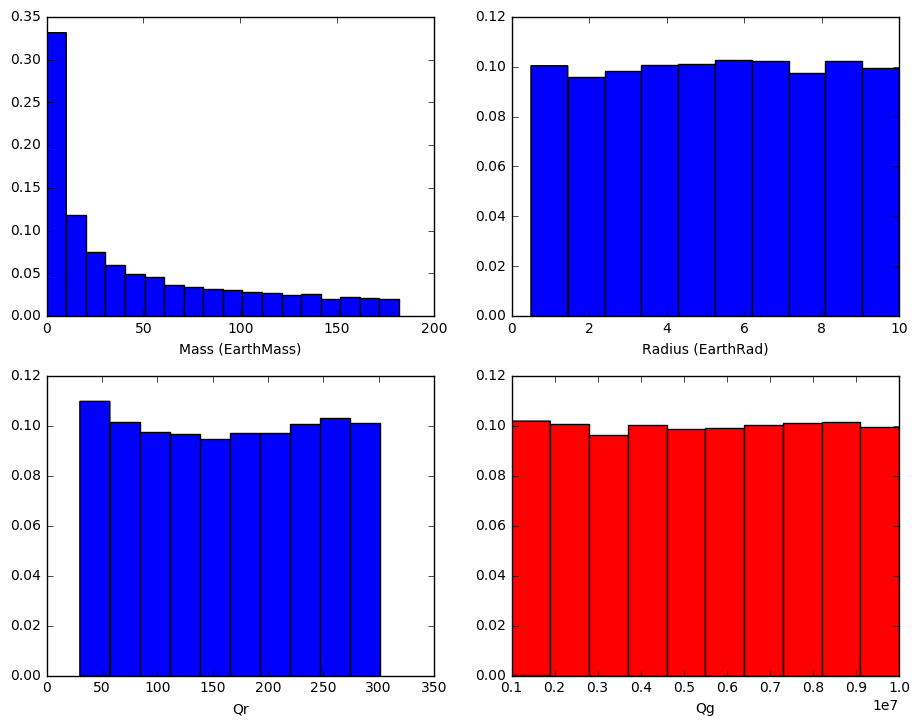

In [8]:
# distributions for c.in of mass, Qp, Radius. 
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_list_c)-min(mass_list_c)
ax[0,0].hist(mass_list_c,bins=18,weights=np.zeros_like(mass_list_c)+1./mass_list_c.size) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(rad_list_c,weights=np.zeros_like(rad_list_c)+1./rad_list_c.size) # Uniform
q_lower = np.where(Qp_c<=301)
q_upper = np.where(Qp_c>301) 
ax[1,0].hist(Qp_c[q_lower],weights=np.zeros_like(Qp_c[q_lower])+1./Qp_c[q_lower].size) 
ax[1,1].hist(Qp_c[q_upper],weights=np.zeros_like(Qp_c[q_upper])+1./Qp_c[q_upper].size,color='r')

ax[0,0].set_xlabel('Mass (EarthMass)')
ax[0,1].set_xlabel('Radius (EarthRad)')
ax[1,0].set_xlabel('Qr')
ax[1,1].set_xlabel('Qg')

print(Qp_c[q_lower].size,Qp_c[q_upper].size,Qp_c[q_lower].size + Qp_c[q_upper].size)

In [6]:
# Parameters by file

# b.in
name_b = 'b'
modules_b = 'eqtide'
sTideModel_b = 'p2'
dMass_b = mass_list_b # sets to earth masses;
dRadius_b = rad_list_b # sets to earth radii
#semi_b defined above
#ecc_b defined above
bForceEqSpin_b = 1
#dRotPeriod = -1 
dObliquity_b = 45 
dRadGyra_b = 0.5
bInvPlane = 1
dInc_b = 0 #distorb
dLongA_b =  #distorb
dArgP_b = dArgP_b #distorb
sOrbitModel_b = 'rd4' #distorb
bOutputLapl_b = 0 #distorb
dPrecA_b = dPrecA_b #distrot
bCalcDynEllip_b = 1 #distrot
dTidalQ_b = dTidalQ_b 
dK2_b = 0.3
#dMaxLockDiff = 0.1 
saTidePerts_b = 'star'
saOutputOrder_b = 'Time Semim Ecce Obliquity SurfEnFluxEqtide LongP' #precA only for distrot, Incl and LongA for Distorb

# c.in
name_c = 'c'
modules_c = 'eqtide distorb'
sTideModel_c = 'p2'
dMass_c = mass_list_c # sets to earth masses; this isnt working!!
dRadius_c = rad_list_c # sets to earth radii
#semi_c defined above
#ecc_c defined above
bForceEqSpin_c = 1
#dRotPeriod = -1 
dObliquity_c = 45 
dRadGyra_c = 0.5
dInc_c = dInc_c
dLongA_c = dLongA_c
dArgP_c = dArgP_c
sOrbitModel_c = 'rd4'
bOutputLapl_c = 0
dTidalQ_c = dTidalQ_c 
dK2_c = 0.3
#dMaxLockDiff = 0.1 
saTidePerts_c = 'star'
saOutputOrder_c = 'Time Semim Ecce LongP' #change to include Incl and LongA for Distorb runs

#star.in
name_star = 'star'
modules_star = 'eqtide'
dMass_star = dMass_star #solar masses;
dRadius_star = dMass_star * 0.0048 # * ratio of solar radii to au
dObliquity_star = 0  
bForceEqSpin_star = 1
dRotPeriod_star = -30 
dRadGyra_star = 0.5 
dTidalQ_star = dTidalQ_star
dK2_star = 0.3 
saTidePerts_star = 'b'
saOutputOrder_s = 'Time'

#vpl.in
Sys_name = 'system'
iVerbose = 5
bOverwrite = 1
saBodyFiles = 'star.in b.in'  #c.in for distorb
UnitMass = 'solar' 
UnitLength = 'aU'  
UnitTime = 'YEARS'
UnitAngle = 'd'
UnitTemp = 'K'
bDoLog = 1
iDigits = 6
dMinValue = 10**(-10)
bDoForward = 1
bVarDt = 1
dEta = 0.01
dStopTime = 10**10
dOutputTime = 10**9


#any extra conversions for units defined in vpl.in; therefore everything needs to be in M_earth or R_earth.
print ('ICs set.')

#test edit for git update

NameError: name 'dMass_b' is not defined

In [12]:
# checks hill stability
# DONT RUN THIS ONE; TAKES SO LONG

#shutil.rmtree('./runs/')

hill_list = np.array([])

mean_an_b_list = np.array([])
mean_an_c_list = np.array([])
good_hill_list = np.array([])
bad_hill_list = np.array([])
bad_count = 0 

n = 0
while n <= t-1:
    name_idx = '%05i'%n
    os.makedirs('./runs/'+name_idx)
    semi_c_0 = np.array([])
    while True:
        #hill.in
        
        if bad_count == 2:
            semi_c_0 = np.append(semi_c_0,semi_c[n])
            semi_c[n] = semi_c[n] + 0.01
            bad_count = 0 # increases outer mass, should that increase hill stability? 
        incl_b = np.random.uniform(0,5)
        incl_c = np.random.uniform(0,5)
        longasc_b = np.random.uniform(0,360)
        longasc_c = np.random.uniform(0,360)
        argperi_b = np.random.uniform(0,360)
        argperi_c = np.random.uniform(0,360)
        mean_an_b = np.random.uniform(0,360)
        mean_an_c = np.random.uniform(0,360)
        
        innermass_str = str(inner_mass[n])
        outermass_str = str(outer_mass[n])
        strMass_str = str(dMass_star[n])
        semi_str_b = str(semi_b[n])
        semi_str_c = str(semi_c[n])
        ecc_str_b = str(ecc_b[n])
        ecc_str_c = str(ecc_c[n])
        
        incl_str_b = str(incl_b)
        incl_str_c = str(incl_c)
        longasc_str_b = str(longasc_b)
        longasc_str_c = str(longasc_c)
        argperi_str_b = str(argperi_b)
        argperi_str_c = str(argperi_c)
        mean_an_str_b = str(mean_an_b)
        mean_an_str_c = str(mean_an_c)
    
        hill = open('./runs/'+name_idx+'/hill.in','w')
        hill_content = (strMass_str+'\n'
                        +innermass_str+' '+semi_str_b+' '+ecc_str_b+' '+incl_str_b+' '+argperi_str_b+' '+longasc_str_b+' '+mean_an_str_b+'\n'
                        +outermass_str+' '+semi_str_c+' '+ecc_str_c+' '+incl_str_c+' '+argperi_str_c+' '+longasc_str_c+' '+mean_an_str_c+'\n'
                        +'body\n')
        hill.write(hill_content)
        hill.close()
    
        wd = './runs/'+name_idx
        hill = subprocess.call(['hillstab hill.in > hill_log'], shell=True, cwd = wd )
        hill_log = open(wd+'/hill_log','r')
        hill_content = hill_log.read()
        hill_content = hill_content.split()
        hill_exact = hill_content[1]
        hill_exact = float(hill_exact)
        if hill_exact < 1: # push out semi so that hill stab > 1
            bad_count += 1
            continue
        elif hill_exact >= 1:
            hill_list = np.append(hill_list,hill_exact)
            dInc_b = np.append(dInc_b,incl_b)
            dInc_c = np.append(dInc_c,incl_c)
            dLongA_b = np.append(dLongA_b,longasc_b)
            dLongA_c = np.append(dLongA_c,longasc_c)
            dArgP_b = np.append(dArgP_b,argperi_b)
            dArgP_c = np.append(dArgP_c,argperi_c)
            mean_an_b_list = np.append(mean_an_b_list,mean_an_b)
            mean_an_c_list = np.append(mean_an_c_list,mean_an_c)
            good_hill_list = np.append(good_hill_list,name_idx)
            break
        
    n += 1
print('Hill Stability determined')

# good = stab  > 1
# bad = instab < 1

Hill Stability determined


In [14]:
# now we need to save the above generated ICs to a file
# so that we dont have to run this long ass script again...
# saves all ICs; remember to upload the corresponding files to git
import shelve
stable_ICs = shelve.open('stable_ICs')
stable_ICs['ecc_b'] = ecc_b
stable_ICs['ecc_c'] = ecc_c
stable_ICs['semi_b'] = semi_b
stable_ICs['semi_c'] = semi_c
stable_ICs['dInc_b'] = dInc_b
stable_ICs['dInc_c'] = dInc_c
stable_ICs['dLongA_b'] = dLongA_b
stable_ICs['dLongA_c'] = dLongA_c
stable_ICs['dArgP_b'] = dArgP_b
stable_ICs['dArgP_c'] = dArgP_b
stable_ICs['mean_an_b'] = mean_an_b_list
stable_ICs['mean_an_c'] = mean_an_c_list
stable_ICs['good_hill'] = good_hill_list
stable_ICs['bad_hill'] = bad_hill_list
stable_ICs['dPrecA_b'] = dPrecA_b
stable_ICs['dMass_star'] = dMass_star
stable_ICs['dRadius_star'] = dRadius_star
stable_ICs['dMass_b'] = dMass_b
stable_ICs['dMass_c'] = dMass_c
stable_ICs['dRadius_b'] = dRadius_b
stable_ICs['dRadius_c'] = dRadius_c
stable_ICs['dTidalQ_b'] = dTidalQ_b
stable_ICs['dTidalQ_c'] = dTidalQ_c
stable_ICs['dTidalQ_star'] = Qstar
stable_ICs['dStopTime'] = dStopTime
stable_ICs.close()

In [ ]:
# distorb as well
# distrot? (w/ and w/o) not on c
# change obl_b = 45 deg
# case barnes et al 2011 origin and dynamics epsilon andromeda --> mutual incl. (incl and longasc to get). 
# dPrecA = np.random.uniform(0,360)
# change of semi over 10gyrs (for distorb and +distrot case)
# vplot both and send em
# separate w/ semi of b w/ both cases (distorb+distrot and only distorb) 












'''
s = 0      #runs each simulation
while s <= t-1:
    name_idx = '%05i'%s
    folder_name = name_idx
    working_directory = './runs/'+folder_name
    p = subprocess.call(['vplanet vpl.in'], shell=True, cwd = working_directory)
    s += 1
    continue



print('Runs Completed')
'''